In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from ortools.linear_solver import pywraplp
import random
pd.options.display.max_rows = 5000
pd.options.display.max_columns = 500

In [2]:
###
## Load dataframe where each row is a single applicant
###

df = pd.read_csv('./df_test.csv')
df['ml_outcomes'] = df['ml_outcomes']#.round(2)# + df['R']*0.13


In [52]:
len(df)

670483

In [51]:
len(df[['R','T']].drop_duplicates())

229

In [3]:
df = df[df['R']==0]

In [4]:
df['R'] = np.random.randint(0, 2, df.shape[0])

In [5]:
FRAC_ADMIT = df[['A']].sum()/len(df)


In [6]:
FRAC_ADMIT

A    0.523373
dtype: float64

In [7]:
len(df)

670483

<AxesSubplot:>

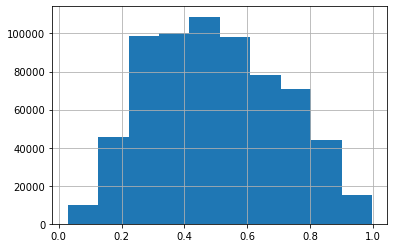

In [8]:
df['ml_outcomes'].hist()

In [9]:
##
# R = race, T = test score, ml_outcomes = expected utility from admitting, 
# ml_outcomes_{} counterfactual utility given race 
##

df[['R','T','ml_outcomes','T_black','T_white','ml_outcomes_black','ml_outcomes_white','ml_outcomes_decision','B_p']].sort_values(by='ml_outcomes')



,R,T,ml_outcomes,T_black,T_white,ml_outcomes_black,ml_outcomes_white,ml_outcomes_decision,B_p
87558,1,10,0.028493,9,10,-3.828057,-3.529184,0,0
601095,1,10,0.028493,11,10,-3.670390,-3.529184,0,0
724501,1,10,0.028493,8,10,-3.906891,-3.529184,0,0
275905,1,11,0.030758,8,11,-3.906891,-3.450350,0,0
937351,0,12,0.033198,11,12,-3.670390,-3.371517,0,0
...,...,...,...,...,...,...,...,...,...
509159,1,124,0.995755,106,124,3.818789,5.457832,1,1
111706,0,125,0.996076,107,125,3.897623,5.536665,1,1
585166,0,127,0.996646,110,127,4.134123,5.694332,1,1
142019,1,129,0.997134,112,129,4.291790,5.851999,1,1


In [10]:
###
## Get total utility from admitting people in a stratum 
###

df_ = df[['R','T','ml_outcomes']].groupby(['R','T']).sum().reset_index()

In [11]:
###
## Get number of people in each stratum
###

df_count = df[['R','T','ml_outcomes']].groupby(['R','T']).count().reset_index()
df_count.columns = ['R','T','Count']
df_count['N'] = df_count['Count']

In [12]:
###
## Get boards passage probability in each stratum
###

df_prob = df[['R','T','B_p']].groupby(['R','T']).mean().reset_index()
df_prob.columns = ['R','T','ml_outcomes_prob']

#df_prob = df[['R','T','ml_outcomes_prob']]

In [13]:
###
## Merge summary tables to get one table with Race, Test Score, SUM(Utility), COUNT(applicants), E(Y(1)|X )
###

dff = df_.merge(df_count[['N']],left_index=True,right_index=True)
dff = dff.merge(df_prob[['ml_outcomes_prob']],left_index=True,right_index=True).sort_values(by='ml_outcomes',ascending=False).reset_index().sort_values(by='index').reset_index()



In [14]:
# final info table
dff.sort_values(by='ml_outcomes_prob')

,level_0,index,R,T,ml_outcomes,N,ml_outcomes_prob
0,226,0,0,12,0.099593,3,0.000000
119,217,119,1,16,0.764172,17,0.000000
117,221,117,1,14,0.270535,7,0.000000
116,224,116,1,13,0.179115,5,0.000000
115,225,115,1,12,0.132790,4,0.000000
113,227,113,1,10,0.085480,3,0.000000
7,200,7,0,19,1.969443,35,0.000000
114,228,114,1,11,0.030758,1,0.000000
1,222,1,0,13,0.250761,7,0.000000
4,218,4,0,16,0.494464,11,0.000000


In [15]:
dff['Pr(X=X_j)'] = dff['N']/(dff['N']).sum()

In [16]:
dff[dff['R']==1].sort_values(by='T')

,level_0,index,R,T,ml_outcomes,N,ml_outcomes_prob,Pr(X=X_j)
113,227,113,1,10,0.085480,3,0.000000,0.000004
114,228,114,1,11,0.030758,1,0.000000,0.000001
115,225,115,1,12,0.132790,4,0.000000,0.000006
116,224,116,1,13,0.179115,5,0.000000,0.000007
117,221,117,1,14,0.270535,7,0.000000,0.000010
118,219,118,1,15,0.416858,10,0.100000,0.000015
119,217,119,1,16,0.764172,17,0.000000,0.000025
120,203,120,1,17,1.211493,25,0.040000,0.000037
121,202,121,1,18,1.462355,28,0.071429,0.000042
122,193,122,1,19,2.813490,50,0.060000,0.000075


In [17]:
df_decisions = None
max_utility = -1.0

for C_y in np.linspace(0.0,1.0,1001):
    dff['alpha_j'] = dff['Pr(X=X_j)']* (dff['ml_outcomes_prob'] - C_y)
    solver = pywraplp.Solver.CreateSolver('GLOP')

    
    applicant_stratum = []
    vars_cache = {}
    alpha_j = {}
    
    # Objective: Maximize the expected utility of the admitted students
    objective = solver.Objective()
    
    # For each stratum
    for ix, row in dff.iterrows():
        # probability of admission
        numvar = solver.NumVar(0.0, 1.0, str(ix))
        
        # store variable by index, and also by stratum R, T
        applicant_stratum.append(numvar)
        vars_cache[(row['R'],row['T'])] = numvar
        
        alpha_j[(row['R'],row['T'])] = row['alpha_j']
        
        # Benefit of admitting people is total utility in that stratum
        objective.SetCoefficient(applicant_stratum[ix], float(row['ml_outcomes']))
        
    objective.SetMaximization()

    # Constraint: At most K applicants
    K = int(len(df)*FRAC_ADMIT)
    admit_quota = solver.Constraint(0, K)
    
    # Total admits cannot exceed K 
    for ix, row in dff.iterrows():
        admit_quota.SetCoefficient(applicant_stratum[ix], float(row['N']))
    
    
    sum_alpha = 0
    R = 1 
    
    for T in list(dff[dff['R']==R]['T']):
        sum_alpha+= alpha_j[(R,T)] 
        
    cf_black = solver.Constraint(sum_alpha, sum_alpha)
    
    for T in list(dff[dff['R']==R]['T']):    
        cf_black.SetCoefficient(vars_cache[(R,T)], alpha_j[(R,T)] )    
    
    sum_alpha = 0
    R = 0
    
    for T in list(dff[dff['R']==R]['T']):
        sum_alpha+= alpha_j[(R,T)] 
        
    cf_white = solver.Constraint(sum_alpha, sum_alpha)
    
    for T in list(dff[dff['R']==R]['T']):    
        cf_white.SetCoefficient(vars_cache[(R,T)], alpha_j[(R,T)] )
        
    status = solver.Solve()

    if status != 2:
        TOTAL_UTILITY = 0
        for ix, row in dff.iterrows():
            TOTAL_UTILITY += float(row['ml_outcomes'])* vars_cache[(row['R'],row['T'])].solution_value()
        print(C_y,TOTAL_UTILITY)
        
        if TOTAL_UTILITY > max_utility:
            row = []
            admit = []
        
            for i in applicant_stratum:
                row.append(int(str(i)))
                admit.append(i.solution_value())
            
            df_decisions = pd.DataFrame({'row_id':row,'decision':admit})
            
            max_utility = TOTAL_UTILITY


0.323 232593.73329185124
0.324 232306.13757617734
0.325 232016.93219729373
0.326 231727.63651406355
0.327 231429.02543843872
0.328 231128.316197653
0.329 230826.66351534735
0.33 230524.71957175498
0.331 230222.5569259313
0.332 229920.40852605822
0.333 229618.2745268564
0.334 229316.07288265746
0.335 229013.671419411
0.336 228711.24123425872
0.337 228408.781736384
0.338 228106.29231865428
0.339 227803.67381944714
0.34 227500.30591446432
0.341 227194.70232736028
0.342 226888.57291600714
0.343 226582.0671249599
0.34400000000000003 226275.56621344262
0.34500000000000003 225969.07022273628
0.34600000000000003 225662.57898836563
0.34700000000000003 225355.8045133794
0.34800000000000003 225048.80997663873
0.34900000000000003 224741.82182565282
0.35000000000000003 224434.84011521842
0.35100000000000003 224127.86490075974
0.352 223820.8962383399
0.353 223513.74660034486
0.354 223206.48297041614
0.355 222899.19937575108
0.356 222591.89534415372
0.357 222284.5703884183
0.358 221977.1947121055
0.3

0.636 132688.0809871113
0.637 132352.41240527914
0.638 132016.6543953447
0.639 131680.7912396432
0.64 131344.93308383017
0.641 131009.07986217787
0.642 130673.22375147988
0.643 130337.06785524447
0.644 130000.91238390541
0.645 129664.67715652971
0.646 129327.66535976552
0.647 128990.65377197889
0.648 128653.64337025708
0.649 128316.63414355388
0.65 127979.62608095934
0.651 127642.61917169817
0.652 127305.58424240952
0.653 126968.29729472706
0.654 126630.71017892941
0.655 126293.12369337626
0.656 125955.53783029354
0.657 125617.95258203415
0.658 125280.08445770963
0.659 124941.3513348496
0.66 124601.89210549097
0.661 124262.42851158848
0.662 123922.53271123771
0.663 123582.08413164246
0.664 123241.47905701223
0.665 122900.34918578892
0.666 122556.03020630505
0.667 122206.52839009975
0.668 121850.12347076001
0.669 121491.7889777126
0.67 121130.09224083663
0.671 120760.19467896354
0.672 120388.19108703978
0.673 120016.16993222802
0.674 119639.32650825665
0.675 119258.91760837998
0.676 118

## Add CF Predictive Parity Constraints

In [18]:
df_decisions

,row_id,decision
0,0,0.000000
1,1,0.000000
2,2,0.000000
3,3,0.000000
4,4,0.000000
5,5,0.000000
6,6,0.000000
7,7,1.000000
8,8,0.000000
9,9,0.000000


In [19]:
dff.merge(df_decisions,left_index=True,right_index=True).sort_values(by='ml_outcomes',ascending=False)

,level_0,index,R,T,ml_outcomes,N,ml_outcomes_prob,Pr(X=X_j),alpha_j,row_id,decision
46,0,46,0,58,5743.487878,10195,0.560765,0.015205,-0.006679,46,1.000000
47,1,47,0,59,5591.097254,9596,0.589204,0.014312,-0.005879,47,0.915178
45,2,45,0,57,5559.583535,10222,0.542164,0.015246,-0.006980,45,1.000000
160,3,160,1,57,5528.582142,10165,0.542843,0.015161,-0.006931,160,1.000000
48,4,48,0,60,5516.847218,9169,0.609227,0.013675,-0.005344,48,1.000000
161,5,161,1,58,5506.311968,9774,0.551770,0.014578,-0.006534,161,1.000000
44,6,44,0,56,5477.571812,10448,0.518568,0.015583,-0.007502,44,1.000000
159,7,159,1,56,5471.280573,10436,0.512840,0.015565,-0.007583,159,1.000000
162,8,162,1,59,5459.418638,9370,0.578335,0.013975,-0.005893,162,1.000000
43,9,43,0,55,5441.395945,10784,0.501669,0.016084,-0.008015,43,1.000000


In [20]:
xxx_ = dff.merge(df_decisions,left_index=True,right_index=True).sort_values(by='ml_outcomes',ascending=False)
xxx_.sort_values(by='T')

,level_0,index,R,T,ml_outcomes,N,ml_outcomes_prob,Pr(X=X_j),alpha_j,row_id,decision
113,227,113,1,10,0.085480,3,0.000000,0.000004,-0.000004,113,0.000000
114,228,114,1,11,0.030758,1,0.000000,0.000001,-0.000001,114,0.000000
0,226,0,0,12,0.099593,3,0.000000,0.000004,-0.000004,0,0.000000
115,225,115,1,12,0.132790,4,0.000000,0.000006,-0.000006,115,0.000000
116,224,116,1,13,0.179115,5,0.000000,0.000007,-0.000007,116,0.000000
1,222,1,0,13,0.250761,7,0.000000,0.000010,-0.000010,1,0.000000
117,221,117,1,14,0.270535,7,0.000000,0.000010,-0.000010,117,0.000000
2,223,2,0,14,0.193239,5,0.200000,0.000007,-0.000006,2,0.000000
3,220,3,0,15,0.333486,8,0.125000,0.000012,-0.000010,3,0.000000
118,219,118,1,15,0.416858,10,0.100000,0.000015,-0.000013,118,0.000000


In [21]:
xxx = dff.merge(df_decisions,left_index=True,right_index=True).sort_values(by='ml_outcomes',ascending=False)
xxx

,level_0,index,R,T,ml_outcomes,N,ml_outcomes_prob,Pr(X=X_j),alpha_j,row_id,decision
46,0,46,0,58,5743.487878,10195,0.560765,0.015205,-0.006679,46,1.000000
47,1,47,0,59,5591.097254,9596,0.589204,0.014312,-0.005879,47,0.915178
45,2,45,0,57,5559.583535,10222,0.542164,0.015246,-0.006980,45,1.000000
160,3,160,1,57,5528.582142,10165,0.542843,0.015161,-0.006931,160,1.000000
48,4,48,0,60,5516.847218,9169,0.609227,0.013675,-0.005344,48,1.000000
161,5,161,1,58,5506.311968,9774,0.551770,0.014578,-0.006534,161,1.000000
44,6,44,0,56,5477.571812,10448,0.518568,0.015583,-0.007502,44,1.000000
159,7,159,1,56,5471.280573,10436,0.512840,0.015565,-0.007583,159,1.000000
162,8,162,1,59,5459.418638,9370,0.578335,0.013975,-0.005893,162,1.000000
43,9,43,0,55,5441.395945,10784,0.501669,0.016084,-0.008015,43,1.000000


In [22]:
len(xxx_)

229

In [23]:
xxx.to_csv('./decision.csv')

In [24]:
xxx

,level_0,index,R,T,ml_outcomes,N,ml_outcomes_prob,Pr(X=X_j),alpha_j,row_id,decision
46,0,46,0,58,5743.487878,10195,0.560765,0.015205,-0.006679,46,1.000000
47,1,47,0,59,5591.097254,9596,0.589204,0.014312,-0.005879,47,0.915178
45,2,45,0,57,5559.583535,10222,0.542164,0.015246,-0.006980,45,1.000000
160,3,160,1,57,5528.582142,10165,0.542843,0.015161,-0.006931,160,1.000000
48,4,48,0,60,5516.847218,9169,0.609227,0.013675,-0.005344,48,1.000000
161,5,161,1,58,5506.311968,9774,0.551770,0.014578,-0.006534,161,1.000000
44,6,44,0,56,5477.571812,10448,0.518568,0.015583,-0.007502,44,1.000000
159,7,159,1,56,5471.280573,10436,0.512840,0.015565,-0.007583,159,1.000000
162,8,162,1,59,5459.418638,9370,0.578335,0.013975,-0.005893,162,1.000000
43,9,43,0,55,5441.395945,10784,0.501669,0.016084,-0.008015,43,1.000000


In [25]:
(xxx['ml_outcomes']*xxx['decision']).sum()

232593.7332918512

In [26]:
def maxMLOutcomes(frac_black=0.01):
    black_admits = int(K*frac_black)
    white_admits = int(K*(1-frac_black))
    
    b = df[df['R']==1].sort_values(by='ml_outcomes',ascending=False).head(n=black_admits)
    w = df[df['R']==0].sort_values(by='ml_outcomes',ascending=False).head(n=white_admits)
    
    return b['B_p'].sum() + w['B_p'].sum()    

In [27]:
def maxMLOutcomesBlack(frac_black=0.01):
    black_admits = int(K*frac_black)
    white_admits = int(K*(1-frac_black))
    
    b = df[df['R']==1].sort_values(by='ml_outcomes',ascending=False).head(n=black_admits)
    w = df[df['R']==0].sort_values(by='ml_outcomes',ascending=False).head(n=white_admits)
    
    return b['B_p'].sum()   

In [28]:
df['key'] = df['R'].astype(str)+'_'+df['T'].astype(str)
xxx['key'] = xxx['R'].astype(str)+'_'+xxx['T'].astype(str)

In [29]:
len(xxx)

229

In [30]:
admit_decisions = df.merge(xxx,how='left',on='key')
admit_decisions['decision_random'] = pd.Series([random.random() for x in range(0,len(admit_decisions))]) < FRAC_ADMIT['A']


FRAC_BLACK_POLICY = (admit_decisions['R_y'] * admit_decisions['decision']).sum()/admit_decisions['decision'].sum()
SUM_BP_POLICY = ( admit_decisions['B_p'] * admit_decisions['decision']).sum()

FRAC_RANDOM_POLICY = (admit_decisions['R_y'] * admit_decisions['decision_random']).sum()/admit_decisions['decision_random'].sum()
SUM_BP_RAND_POLICY = ( admit_decisions['B_p'] * admit_decisions['decision_random']).sum()


In [31]:
str(FRAC_BLACK_POLICY),str(SUM_BP_POLICY)

('0.4991907450954305', '231981.88999999998')

In [32]:
(xxx['N']*xxx['decision']).sum()/len(df)

0.5233734486929572

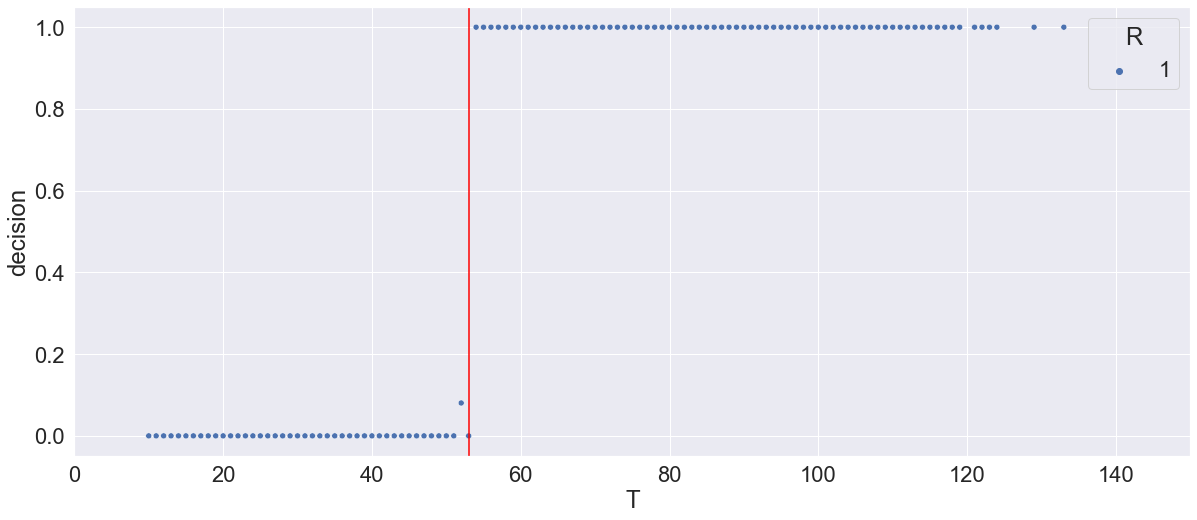

In [33]:
sns.set(rc={'figure.figsize':(20,8.27)})
sns.set(font_scale=2)  # crazy big
g = sns.scatterplot(x='T',y='decision',hue='R',data=xxx[xxx['R']==1])
g.set(xlim=(0, 150))
plt.axvline(53, 0,1,color='red')


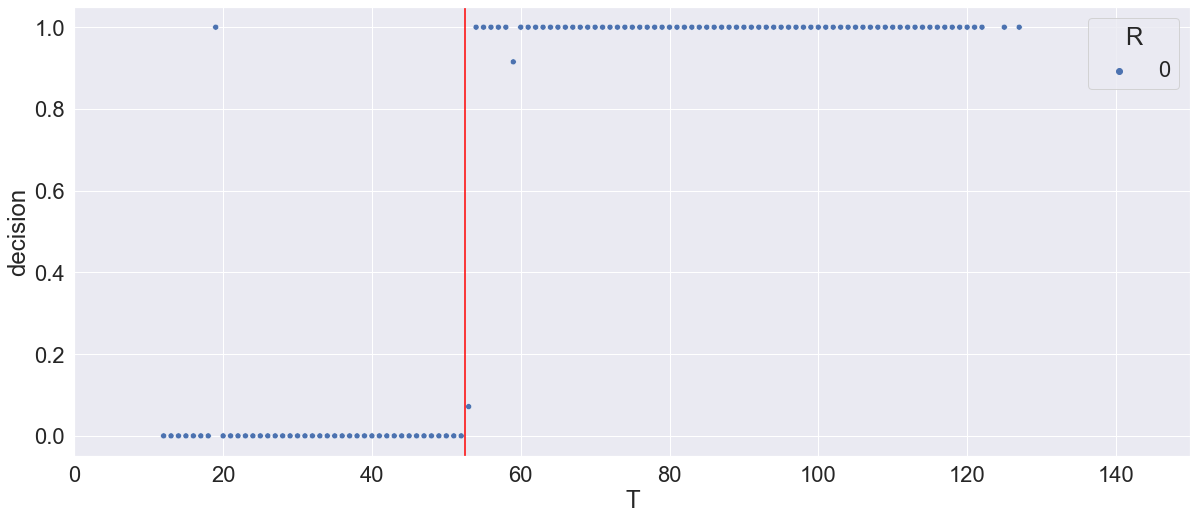

In [34]:
sns.set(rc={'figure.figsize':(20,8.27)})
sns.set(font_scale=2)  # crazy big
g = sns.scatterplot(x='T',y='decision',hue='R',data=xxx[xxx['R']==0])
g.set(xlim=(0, 150))
plt.axvline(52.5, 0,1,color='red')



In [35]:
admit_decisions[admit_decisions['decision']==0][['R_x','B_p']].groupby(['R_x']).mean()

,B_p
R_x,
0,0.31222
1,0.31510


In [36]:
str(FRAC_BLACK_POLICY),str(SUM_BP_POLICY)

('0.4991907450954305', '231981.88999999998')

In [37]:
SUM_BP_POLICY/(FRAC_ADMIT*len(df))

A    0.661081
dtype: float64

In [38]:
str(FRAC_BLACK_POLICY),str(SUM_BP_POLICY)

('0.4991907450954305', '231981.88999999998')

In [39]:
admit_decisions[admit_decisions['decision']==1]['B_p'].mean()

0.6639606432190323

In [40]:
(admit_decisions['decision'] * admit_decisions['ml_outcomes_x']).sum()

232593.7332918513

In [41]:
(admit_decisions['decision'] * admit_decisions['B_p']).sum()

231981.88999999998

In [42]:
admit_decisions[admit_decisions['decision']==1]['B_p'].sum()

226062

In [43]:
(admit_decisions['decision'] * admit_decisions['B_p']).sum()/(len(admit_decisions)*FRAC_ADMIT)

A    0.661081
dtype: float64

In [44]:
(admit_decisions['decision'].sum())

350913.0000000001

In [45]:
admit_decisions['rand'] = pd.Series([random.random() for x in range(0,len(admit_decisions))])
admit_decisions['dec_binary'] = admit_decisions['rand'] < admit_decisions['decision']
admit_decisions[admit_decisions['dec_binary']==0][['R_x','B_p']].groupby(['R_x']).mean()

,B_p
R_x,
0,0.322943
1,0.323053


In [46]:
admitted = admit_decisions.sort_values(by='ml_outcomes_x',ascending=False).head(n=int(FRAC_ADMIT*len(df)))

In [47]:
(admitted['decision']*admitted['ml_outcomes_x']).sum()

231852.41722435228

In [48]:
df[['ml_outcomes','T']].groupby(['T']).mean()

,ml_outcomes
T,
10,0.028493
11,0.030758
12,0.033198
13,0.035823
14,0.038648
15,0.041686
16,0.044951
17,0.048460
18,0.052227
